In [9]:
import scipy.stats as stats
import matplotlib.pyplot as plt
%matplotlib inline
from IPython.core.pylabtools import figsize
figsize(12.5, 4)
import numpy as np
from mpl_toolkits.mplot3d import Axes3D

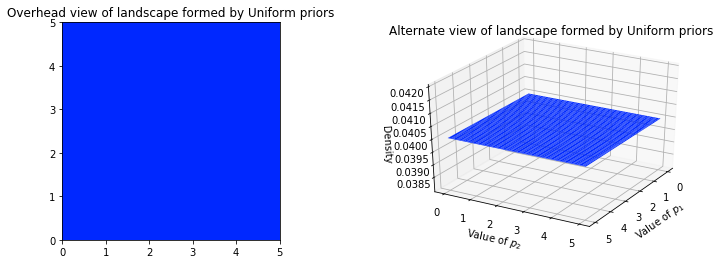

In [2]:
jet = plt.cm.jet
fig = plt.figure()

x = y = np.linspace(0, 5, 100)
X, Y = np.meshgrid(x, y)

plt.subplot(121)
uni_x = stats.uniform.pdf(x, loc=0, scale=5)
uni_y = stats.uniform.pdf(y, loc=0, scale=5)
M = np.dot(uni_x[:, None], uni_y[None, :])
im = plt.imshow(M, interpolation='none', origin='lower',
                cmap=jet, vmax=1, vmin=-.15, extent=(0, 5, 0, 5))
plt.xlim(0, 5)
plt.ylim(0, 5)
plt.title('Overhead view of landscape formed by Uniform priors')

ax = fig.add_subplot(122, projection='3d')
ax.plot_surface(X, Y, M, cmap=plt.cm.jet, vmax=1, vmin=-.15)
ax.view_init(azim=390)
ax.set_xlabel('Value of $p_1$')
ax.set_ylabel('Value of $p_2$')
ax.set_zlabel('Density')
plt.title('Alternate view of landscape formed by Uniform priors')

In [3]:
from urllib.request import urlretrieve
urlretrieve('https://git.io/vXt6b', 'data/mixture_dara.csv')

('data/mixture_dara.csv', <http.client.HTTPMessage at 0x48013c8>)

[ 115.85679142  152.26153716  178.87449059  162.93500815  107.02820697
  105.19141146  118.38288501  125.3769803   102.88054011  206.71326136] ...


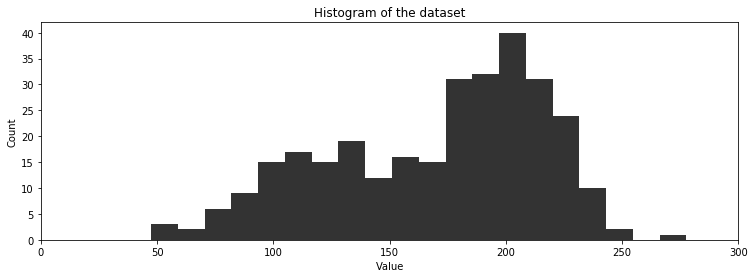

In [4]:
figsize(12.5, 4)
data = np.loadtxt('data/mixture_dara.csv', delimiter=',')
plt.hist(data, bins=20, color='k', histtype='stepfilled', alpha=0.8)
plt.title('Histogram of the dataset')
plt.xlim([0, 300])
plt.ylim([0, None])
plt.xlabel('Value')
plt.ylabel('Count')
print(data[:10], '...')

二峰性がある(正規分布が二つあるようにみえる)  

提案できるこのデータの生成アルゴリズム
1. 各データ点について、確率 $p$ でクラスタ0を選択
  - クラスタ0を選択しなければクラスタ1を選択 (確率 $1-p$)
1. $\mu_i$ と $\sigma_i$ の正規分布から値をひとつサンプリングする
  - ここで $i$ はクラスタの番号
1. Repeat



In [5]:
import pymc3 as pm
import theano.tensor as T

In [6]:
with pm.Model() as model:
    p1 = pm.Uniform('p', 0., 1.)
    p2 = 1 - p1
    p = T.stack([p1, p2])
    assignment = pm.Categorical('assignment', p,
                                shape=data.shape[0],
                                testval=np.random.randint(0, 2, data.shape[0]))

print('prior assignment, with p = {}:'.format(p1.tag.test_value))
print(assignment.tag.test_value[:10])

prior assignment, with p = 0.5:
[0 1 0 0 0 1 1 0 0 0]


二つの正規分布の標準偏差が違ってみえる  

$$
\tau = \frac{1}{\sigma^2}
$$

$\mu$ はそれぞれ120, 190くらいっぽい  

In [7]:
with model:
    sds = pm.Uniform('sds', 0, 100, shape=2)
    centers = pm.Normal('centers',
                        mu=np.array([120, 190]),
                        sd=np.array([10, 10]),
                        shape=2)
    center_i = pm.Deterministic('center_i', centers[assignment])
    sd_i = pm.Deterministic('sd_i', sds[assignment])
    
    observations = pm.Normal('obs', mu=center_i, sd=sd_i, observed=data)
    
print('Random assignments: {} ...'.format(assignment.tag.test_value[:4]))
print('Assigned center: {} ...'.format(center_i.tag.test_value[:4]))
print('Assigned precision: {}'.format(sd_i.tag.test_value[:4]))

Random assignments: [0 1 0 0] ...
Assigned center: [ 120.  190.  120.  120.] ...
Assigned precision: [ 50.  50.  50.  50.]


In [8]:
with model:
    step1 = pm.Metropolis(vars=[p, sds, centers])
    step2 = pm.ElemwiseCategorical(vars=[assignment])
    trace = pm.sample(25000, step=[step1, step2])

c:\users\owner\anaconda3\envs\py3\lib\site-packages\ipykernel_launcher.py:3: DeprecationWarning: ElemwiseCategorical is deprecated, switch to CategoricalGibbsMetropolis.
  This is separate from the ipykernel package so we can avoid doing imports until
c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:231: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically '
c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:234: UserWarning: Automatic initialization is not supported for discrete variables. Ignoring init argument.
  warnings.warn('Automatic initialization is not supported '
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 25000/25000 [02:23<00:00, 173.88it/s]


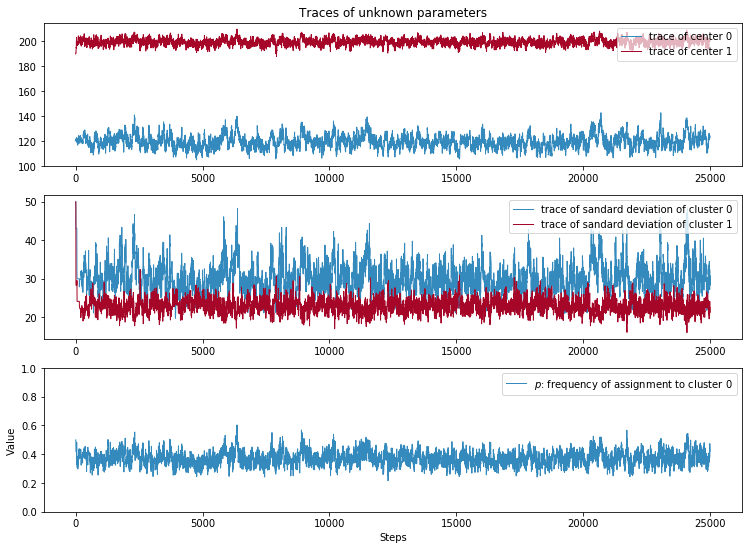

In [10]:
figsize(12.5, 9)

colors = ['#348ABD', '#A60628']

center_trace = trace['centers']

plt.subplot(311)
plt.plot(center_trace[:, 0], label='trace of center 0', c=colors[0], lw=1)
plt.plot(center_trace[:, 1], label='trace of center 1', c=colors[1], lw=1)
plt.title('Traces of unknown parameters')
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.7)

plt.subplot(312)
std_trace = trace['sds']
plt.plot(std_trace[:, 0], label='trace of sandard deviation of cluster 0', c=colors[0], lw=1)
plt.plot(std_trace[:, 1], label='trace of sandard deviation of cluster 1', c=colors[1], lw=1)
plt.legend(loc='upper right')

plt.subplot(313)
p_trace = trace['p']
plt.plot(p_trace, label='$p$: frequency of assignment to cluster 0', c=colors[0], lw=1)
plt.xlabel('Steps')
plt.ylabel('Value')
plt.ylim(0, 1)
plt.legend()

In [11]:
with model:
    trace = pm.sample(50000, step=[step1, step2], trace=trace)

c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:231: UserWarning: Instantiated step methods cannot be automatically initialized. init argument ignored.
  warnings.warn('Instantiated step methods cannot be automatically '
c:\users\owner\anaconda3\envs\py3\lib\site-packages\pymc3\sampling.py:234: UserWarning: Automatic initialization is not supported for discrete variables. Ignoring init argument.
  warnings.warn('Automatic initialization is not supported '
100%|█████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████████| 50000/50000 [04:45<00:00, 174.93it/s]


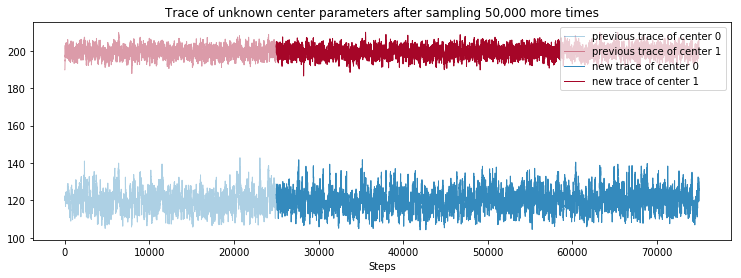

In [12]:
figsize(12.5, 4)
center_trace = trace['centers'][25000:]
prev_trace = trace['centers'][:25000]

x = np.arange(25000)
plt.plot(x, prev_trace[:,0], label='previous trace of center 0',
         lw=1, c=colors[0], alpha=0.4)
plt.plot(x, prev_trace[:,1], label='previous trace of center 1',
         lw=1, c=colors[1], alpha=0.4)

x = np.arange(25000, 75000)
plt.plot(x, center_trace[:, 0], label='new trace of center 0',
         lw=1, c=colors[0])
plt.plot(x, center_trace[:, 1], label='new trace of center 1',
         lw=1, c=colors[1])
plt.title('Trace of unknown center parameters after sampling 50,000 more times')
leg = plt.legend(loc='upper right')
leg.get_frame().set_alpha(0.8)
plt.xlabel('Steps')